# Setup

In [1]:
import os
import pandas as pd
pd.set_option("display.max_colwidth", None)

os.environ["AZURE_OPENAI_ENDPOINT"] = "https://dalle3-swo.openai.azure.com/"
os.environ["AZURE_OPENAI_API_KEY"] = "e51119f8d8774069a6594d92ccf7a70d"

In [2]:
from langchain_community.utilities import GoogleSearchAPIWrapper
from langchain_community.vectorstores import Chroma
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings, OpenAIEmbeddings
from langchain_core.output_parsers import BaseOutputParser
from typing import List, Optional
import re
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import chain
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_core.output_parsers import StrOutputParser

# LLM
llm = AzureChatOpenAI(
    openai_api_version="2024-02-15-preview",
    azure_deployment="gpt-35-turbo",
    temperature=0
) 

gpt_35_turbo_16k = AzureChatOpenAI(
    openai_api_version="2024-02-15-preview",
    azure_deployment="gpt-35-turbo-16k",
    temperature=0
) 

smart_llm = AzureChatOpenAI(
    openai_api_version="2024-02-15-preview",
    azure_deployment="gpt-4",
    temperature=0
) 
gpt_35_turbo_instruct = AzureChatOpenAI(
    openai_api_version="2024-02-15-preview",
    azure_deployment="gpt-35-turbo-instruct",
    temperature=0
) 
# Embedding
embeddings = AzureOpenAIEmbeddings(
    azure_deployment="text-embedding-ada-002",
    openai_api_version="2024-02-15-preview",
)

embeddings_3_large = AzureOpenAIEmbeddings(
    azure_deployment="text-embedding-3-large",
    openai_api_version="2024-02-15-preview",
)

# Test questions

In [4]:
question_lists = [
    "Who should I contact if I want to ask for my timetable",
    "Which department should I contact if I want to ask about my timetable?",
    "Who should I contact if I want to ask about my attendance",    
    "Which department should I contact if I want to ask about my attendance?",
    "How can I contact Mr. Frazer?",
    "May I ask for Mr. Frazer phone number?",
    "I got a question regarding my exam schedule, who should I contact?",
    "I got a question regarding my exam schedule, what department should I contact?",
    "I want to ask for academic support",
    "I need more information about the Student Tutor programme",
    "I want to know about the Faculty Learning Support programme"
]

# Implementation

## Preprocessing BUV q&a file

In [4]:
from IPython.display import JSON

import json

from unstructured_client import UnstructuredClient
from unstructured_client.models import shared
from unstructured_client.models.errors import SDKError
from unstructured.staging.base import dict_to_elements, elements_to_json

s = UnstructuredClient(
    api_key_auth= "ewGFl9s7G1TtCTEHwaiFRw1OHgRSYT",
    # server_url=DLAI_API_URL,
)

In [5]:
student_handobook_file_path = "../../dataInput/Student Handbook 2023-2024 - Jan 2024. V2.pdf"
with open(student_handobook_file_path, "rb") as f:
    files=shared.Files(
        content=f.read(), 
        file_name=student_handobook_file_path,
    )

req = shared.PartitionParameters(
    files=files,
    strategy='hi_res',
    pdf_infer_table_structure=True, # extract table
    languages=["eng"],
)
try:
    student_handbook_resp = s.general.partition(req)
    dld_elements_student_handbook = dict_to_elements(student_handbook_resp.elements)
except SDKError as e:
    print(e)

In [22]:
import collections
html_categories = [el.category for el in dld_elements_student_handbook]
collections.Counter(html_categories).most_common()

[('NarrativeText', 285),
 ('ListItem', 161),
 ('Title', 143),
 ('Header', 63),
 ('Footer', 38),
 ('Image', 26),
 ('Table', 24),
 ('UncategorizedText', 16),
 ('EmailAddress', 1),
 ('FigureCaption', 1)]

In [28]:
dld_elements_student_handbook[31].to_dict()

{'type': 'Title',
 'element_id': '6cbf6711eb29b7813735321a3b8cc481',
 'text': 'III. An Introduction to British University Vietnam',
 'metadata': {'filetype': 'application/pdf',
  'languages': ['eng'],
  'page_number': 6,
  'parent_id': '142a3575a1844849ffb124db9e854a80',
  'filename': 'Student Handbook 2023-2024 - Jan 2024. V2.pdf'}}

In [60]:
tables_el = [el for el in dld_elements_student_handbook if el.category == 'Table']

In [ ]:
tables_el[5].to_dict()

In [21]:
for ele in dld_elements_student_handbook:
    if ele.category == "Title":
        print(ele.text)
        print("---------")

Contents
---------
I. Introduction to the Student Handbook
---------
II. Welcome statements from the Vice-Chancellor and Chief Academic Officer
---------
A WELCOME STATEMENT FROM THE VICE-CHANCELLOR - PROFESSOR RAY GORDON
---------
Prof. Ray Gordon PhD., MBA, CPA, FAIM Vice-Chancellor and President
---------
A WELCOME STATEMENT FROM THE CHIEF ACADEMIC OFFICER - CHRIS JEFFERY
---------
Chris Jeffery Chief Academic Officer
---------
III. An Introduction to British University Vietnam
---------
A. University Contact Points
---------
General feedback
---------
B. Academic Contact Points
---------
C. Student Academic Support Office
---------
Student Tutor Programme: Your Peer Academic Partners
---------
How to Access Student Tutor Programme
---------
Faculty Learning Support Team: Your Academic Excellence Guides
---------
How to Access Faculty Learning Support:
---------
IV. British University Vietnam Policies
---------
Student Code of Conduct
---------
Student Equal Opportunities and Divers

In [46]:
from unstructured.chunking.title import chunk_by_title
final_elements = chunk_by_title(dld_elements_student_handbook, max_characters = 3000)

In [55]:
final_elements[6].to_dict()

{'type': 'CompositeElement',
 'element_id': '3a3332120e672745b7f47da287609bb8',
 'text': '3  \n\nStudent Handbook 2023-2024\n\nI. Introduction to the Student Handbook\n\nWelcome to British University Vietnam. During your course of study, we aim to not only provide you with an excellent learning experience, but also to help you develop the transferable skills that will prepare you for life after university. This means that as a BUV graduate, you will be fully equipped to succeed in b ot h the workplace and in your personal life. Moreover, you will have all the tools necessary to take on any leadership positions in the future.\n\nThis handbook provides you with essential information to fully utilize your time at British University Vietnam. It is vital to your success and the enjoyment of your experience here that you read this handbook carefully. If there is any unclear information in this handbook, please kindly reach out to any of our university staff, we are happy to assist you with a

### Text loader

Load both q&a file and student handbook file

In [3]:
from langchain_community.document_loaders import AzureAIDocumentIntelligenceLoader

endpoint = "https://di-buv.cognitiveservices.azure.com/"
key = "fe9f945227944764889fd95f3bb2abda"


loader = AzureAIDocumentIntelligenceLoader(
            api_endpoint=endpoint, 
            api_key=key, 
            file_path="../../data/qna/1. BUV-JAN24-FREQUENTLY ASKED QUESTIONS 1.docx", 
            api_model="prebuilt-layout"
)
azure_ai_DI_data = loader.load()

In [5]:
azure_ai_DI_data[0].page_content

'STUDENT\n\nENGAGEMENT\n\nSTUDENT INFORMATION OFFICE\n\nSTUDENTS AND PARENTS’ FREQUENTLY ASKED QUESTIONS\n\nCÁC CÂU HỎI THƯỜNG GẶP DÀNH CHO SINH VIÊN VÀ PHỤ HUYNH\n\nCONTENTS/MỤC LỤC\n\nI. ACADEMIC AND STUDENT OPERATIONS 10\n\n1\\. How can students/parents receive the timetables? / Sinh viên/phụ huynh có thể nhận thời khóa biểu ở đâu? 10\n\n2\\. How does BUV record students’ attendance? / Điểm chuyên cần của sinh viên được BUV quản lý như thế nào? 10\n\n3\\. What should students/parents do if students need to be absent from classes? / Nếu sinh viên cần nghỉ học vì một lý do nào đó, sinh viên/phụ huynh cần phải làm gì? 14\n\n4\\. If the academic results of students are not good enough and students/parents are worried, what can BUV support to improve their performance? / Sinh viên/phụ huynh lo rằng kết quả học tập của sinh viên không đủ tốt, liệu nhà trường có kế hoạch gì trong việc giúp đỡ sinh viên cải thiện kết quả học tập không? 18\n\n5\\. In the students’ timetable, I have seen that

### Splitter

In [4]:
import re  
  
def extract_qna_from_extracted_word(extracted_word):
    raw_splitted_text = re.split(r"\n\nAnswer / Câu trả lời:\n\n", extracted_word)
    q_a_list = []
    for element in raw_splitted_text:
        split_question = re.split(r"\n\n", element)
        if len(split_question) == 1:
            current_quesions = split_question[0]
            q_a_list.append(current_quesions)
        else:
            answer_of_current_quesions, next_question = split_question[:-1], split_question[-1]
            answer_of_current_quesions = "\n\n".join(answer_of_current_quesions)
            q_a_list.extend([answer_of_current_quesions, next_question])
    return q_a_list


In [5]:
list_qna = extract_qna_from_extracted_word(azure_ai_DI_data[0].page_content)
refine_qna_list = list_qna[1:-1]

In [6]:
from langchain.docstore.document import Document

buv_docs = []
for i in range(int(len(refine_qna_list)/2)):
    # page_content is question, metadata is answer
    document = Document(page_content=refine_qna_list[2*i] + "\n\nAnswer / Câu trả lời:\n\n" + refine_qna_list[2*i+1])
    buv_docs.append(document)

In [9]:
print(buv_docs[0].page_content)

How can students/parents receive the timetables? / Sinh viên/phụ huynh có thể nhận thời khóa biểu ở đâu?

Answer / Câu trả lời:

Student’s timetable will be sent to BUV student’s and parent’s emails at the beginning of each semester. Please make sure to provide us with the correct email to the Student Information Office via studentservice@buv.edu.vn to receive the timetable and other information.

Thời khóa biểu của sinh viên sẽ được gửi đến sinh viên và phụ huynh vào đầu mỗi kỳ học qua địa chỉ email BUV của sinh viên và email cá nhân của phụ huynh. Phụ huynh vui lòng đảm cung cấp email chính xác cho Bộ phận Thông tin Sinh viên qua địa chỉ studentservice@buv.edu.vn để kịp thời nhận thời khóa biểu và thông tin khác từ nhà trường.


## Preprocessing student handbook file

In [7]:
from langchain_community.document_loaders.text import TextLoader
loader = TextLoader("../../data/qna/student_handbook_text.txt")
refined_documents = loader.load()

In [8]:
# Parent splitter - Mardown splitter 
from langchain_text_splitters import MarkdownHeaderTextSplitter

headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]

markdown_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=headers_to_split_on, strip_headers=False
)
student_handbook_docs = markdown_splitter.split_text(refined_documents[0].page_content)

## Combine two docs

In [9]:
final_docs =  buv_docs+ student_handbook_docs

## Count token
Per parent document

In [17]:
list_page_content = [doc.page_content for doc in final_docs]

In [18]:
import tiktoken

def num_tokens_from_string(string: str, encoding_name: str = "cl100k_base") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


num_tokens = list(map(num_tokens_from_string, list_page_content))

<Axes: ylabel='Frequency'>

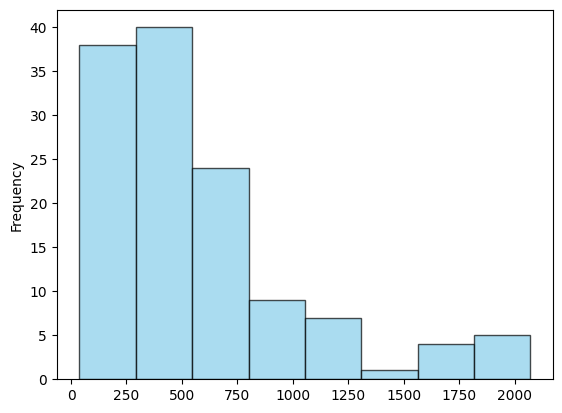

In [19]:
import pandas as pd
# Create a DataFrame from the list
df = pd.DataFrame(num_tokens, columns=['Value'])

# Plot the distribution
df['Value'].plot(kind='hist', bins=8, color='skyblue', edgecolor='black', alpha=0.7)
# df['Value'].plot(kind='kde', color='red')


In [20]:
df.describe()

,Value
count,128.000000
mean,578.593750
std,464.736221
min,38.000000
25%,248.500000
50%,464.000000
75%,694.750000
max,2070.000000


## Retrievers

### Parent document retrievers

In [10]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore, LocalFileStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.storage._lc_store import create_kv_docstore


# This text splitter is used to create the child documents
child_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400, chunk_overlap=100, add_start_index=True
)
# The vectorstore to use to index the child chunks
vectorstore_chunk_zie_400 = Chroma(
    persist_directory="./chroma_db/buv_and_student_handbook_400", embedding_function=embeddings_3_large
)
# The storage layer for the parent documents
# store = InMemoryStore()
fs = LocalFileStore("./parent_document_store/buv_and_student_handbook")
store = create_kv_docstore(fs)
parent_document_retriever = ParentDocumentRetriever(
    vectorstore=vectorstore_chunk_zie_400,
    docstore=store,
    child_splitter=child_splitter,
    search_kwargs={"k": 10},
)

In [11]:
parent_document_retriever.add_documents(final_docs, ids=None)

In [2]:
len(list(store.yield_keys()))

NameError: name 'store' is not defined

### Test chunk size

In [15]:
# chunk_size 300
# text_splitter_300 = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=100)
# docs_300 = text_splitter_300.split_documents(final_docs)
# db_chunk_size_300 = Chroma.from_documents(docs_300, embeddings_3_large,
#                                           persist_directory="buv_and_student_handbook_300_embedding_large")

db_chunk_size_300 = Chroma(persist_directory="buv_and_student_handbook_300_embedding_large",
                           embeddings=embeddings_3_large)


In [16]:
# # chunk_size 300
# text_splitter_350 = RecursiveCharacterTextSplitter(chunk_size=350, chunk_overlap=100)
# docs_350 = text_splitter_350.split_documents(final_docs)
# db_chunk_size_350 = Chroma.from_documents(docs_350, embeddings_3_large, 
#                                           persist_directory="buv_and_student_handbook_350_embedding_large")
db_chunk_size_350 = Chroma(persist_directory="buv_and_student_handbook_350_embedding_large",
                           embeddings=embeddings_3_large)

In [32]:
question_lists

['Who should I contact if I want to ask for my timetable',
 'Which department should I contact if I want to ask about my timetable?',
 'Who should I contact if I want to ask about my attendance',
 'Which department should I contact if I want to ask about my attendance?',
 'How can I contact Mr. Frazer?',
 'May I ask for Mr. Frazer phone number?',
 'I got a question regarding my exam schedule, who should I contact?',
 'I got a question regarding my exam schedule, what department should I contact?',
 'I want to ask for academic support',
 'I need more information about the Student Tutor programme',
 'I want to know about the Faculty Learning Support programme']

In [55]:
a = db_chunk_size_300.similarity_search("May I ask for Mr. Frazer phone number?")

In [58]:
print(a[2].page_content)

If you or your friend are in a medical emergency case and cannot come to Medical Suite, please reach out to our emergency hotline 090 215 7558 for prompt assistance.  
Hours of operation:  
From Monday to Friday, 08:30 - 17:30  
Weekend operations are dependent on events/activities and classes.


In [59]:
a = db_chunk_size_350.similarity_search("May I ask for Mr. Frazer phone number?")

In [60]:
print(a[0].page_content)

and up to 4 minutes 59 seconds after the timetabled end of the session. Students should also immediately inform the Student Information Office on the 2nd floor in person about any FRS issue.


In [61]:
print(a[1].page_content)

If you or your friend are in a medical emergency case and cannot come to Medical Suite, please reach out to our emergency hotline 090 215 7558 for prompt assistance.  
Hours of operation:  
From Monday to Friday, 08:30 - 17:30  
Weekend operations are dependent on events/activities and classes.


In [12]:
a = vectorstore_chunk_zie_400.similarity_search("Which department and how should I contact if I want to ask about my timetable?")

In [15]:
print(a[2].page_content)

| Admission Office Provides support and guidance for inquires relate to all Admissions procedure including pre-arrival inquiries. | admissions@buv.edu.vn |
| - | - |
| Course Office Provides support and guidance for inquires relate to Timetable, Class Arrangement, Status changes, Course Operations, Programme and Module Administration. | courseoffice@buv.edu.vn |


In [1]:
b = parent_document_retriever.invoke("I got a question regarding my exam schedule, who should I contact?")

NameError: name 'parent_document_retriever' is not defined

In [78]:
print(b[0].page_content)

## Academic Misconduct Regulation  
Academic Conduct and Misconduct for IFP/UOL students, please refer to UOL General Regulations and Programme Regulations which can be found here:  
https://www.london.ac.uk/current-students/programme-documents/regulations#undergraduate-29612  
General Regulations AY 2022/23 (for both UOL&IFP) https://www.london.ac.uk/sites/default/files/regulations/generalregs-2022-23-v2.pdf  
UOL Programme Regulations AY 2022/2023  
https://www.london.ac.uk/sites/default/files/progregs-emfss-online-taught-2022-2023-19-07-23.pdf  
IFP Programme Regulations AY 2022/2023  
https://www.london.ac.uk/sites/default/files/regulations/progregs-ifp-2022-2023.pdf  
Academic Misconduct is any action which could give you, or someone else, an unfair advantage in an assessment, including examinations. It is also any actions which could undermine the fairness of assessment and research at the University.  
There are different types of academic misconduct. You can find a list at: htt

#### Reload parent document retriever

In fact, the ParentDocumentRetriever could be replaced by a MultiVectorRetriever instance since the difference between the two is the add_documents method that the ParentDocumentRetriever has.

Refer to here: https://github.com/langchain-ai/langchain/issues/9345

In [5]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore, LocalFileStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.storage._lc_store import create_kv_docstore
from langchain.retrievers import MultiVectorRetriever


# The vectorstore to use to index the child chunks
vectorstore_chunk_zie_400 = Chroma(
    persist_directory="./chroma_db/buv_and_student_handbook_400", embedding_function=embeddings
)
# The storage layer for the parent documents
# store = InMemoryStore()
fs = LocalFileStore("./parent_document_store/buv_and_student_handbook")
store = create_kv_docstore(fs)
parent_document_retriever = MultiVectorRetriever(
    vectorstore=vectorstore_chunk_zie_400,
    docstore=store,
    search_kwargs={"k": 3},
)

In [6]:
question_lists

['Who should I contact if I want to ask for my timetable',
 'Which department should I contact if I want to ask about my timetable?',
 'Who should I contact if I want to ask about my attendance',
 'Which department should I contact if I want to ask about my attendance?',
 'How can I contact Mr. Frazer?',
 'May I ask for Mr. Frazer phone number?',
 'I got a question regarding my exam schedule, who should I contact?',
 'I got a question regarding my exam schedule, what department should I contact?',
 'I want to ask for academic support',
 'I need more information about the Student Tutor programme',
 'I want to know about the Faculty Learning Support programme']

In [7]:
a = vectorstore_chunk_zie_400.similarity_search(question_lists)

In [18]:
print(a[1].page_content)

of Office Hours, the students can email their preferred module team members and request a meeting within those hours. In the case that the students are unable to attend the posted Office Hours, the module teams may be able to meet the students at other times depending on their availability.


In [10]:
b = parent_document_retriever.invoke(question_lists[0])

In [16]:
print(b[1].page_content)

If the academic results of students are not good enough and students/parents are worried, what can BUV support to improve their performance? / Sinh viên/phụ huynh lo rằng kết quả học tập của sinh viên không đủ tốt, liệu nhà trường có kế hoạch gì trong việc giúp đỡ sinh viên cải thiện kết quả học tập không?

Answer / Câu trả lời:

To improve students’ performance in specific modules, the best way is to stay engaged & reach out to the Modules Leaders for their support. This semester, module teams will be posting their “Office Hours” on the front page of their Canvas site near where you find their email address. To make use of Office Hours, the students can email their preferred module team members and request a meeting within those hours. In the case that the students are unable to attend the posted Office Hours, the module teams may be able to meet the students at other times depending on their availability.

Moreover, at BUV, we are dedicated to providing comprehensive academic support

### Rephrase retriever

In [96]:
from langchain.chains import LLMChain
from langchain_core.prompts import PromptTemplate
from langchain.retrievers import RePhraseQueryRetriever

QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an assistant tasked with taking a natural languge query from a user
    and converting it into a query for a vectorstore. 
    Instruction:
    - Strip out all information that is not relevant for the retrieval task and return a new, simplified
    question for vectorstore retrieval. The new user query should be in pirate speech.

    Here is the user query: {question} """,
)
llm_chain = LLMChain(llm=gpt_35_turbo_16k, prompt=QUERY_PROMPT)
retriever_from_llm_chain = RePhraseQueryRetriever(
    retriever=parent_document_retriever, llm_chain=llm_chain
)

In [101]:
a = retriever_from_llm_chain.invoke("Please send me the student code of conduct at BUV for my compliance with the school policy")

In [103]:
print(a[1].page_content)

## Student Code of Conduct  
Being a proud member of the University community means engaging with your studies and supporting others to do so. As a student you are entitled to respect. As a member of our University, we expect you to respect and be tolerant of others, including other students, staff and the public. This means listening to others, celebrating the diversity of our community, and following the University policies, regulations and the law.  
The following list will help you understand what conduct is expected of you as a member of our University community:  
Treat others with tolerance, dignity and respect, either in person or online.  
Follow all University regulations and policies.  
Respect your environment, both on and off campus.  
Treat University property with respect  
Follow health and safety rules and guidelines  
Act within the law and do not negatively impact on the University’s reputation  
Any violation of the conducts or regulations will result in relative di

## Create chain

In [13]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


def format_docs_vectorstore_retriever(docs, num_parent_docs=2):
    return "\n\n".join(doc.page_content for doc in docs[:num_parent_docs])

def format_docs_parent_retriever(docs, num_parent_docs=2):
    return "\n\n".join(doc.page_content for doc in docs[:num_parent_docs])

template = """
You are an AI assistant that helps students answering specific questions based on student handbook. 

Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

Context:
{context}

Question: 
{question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

from operator import itemgetter
# rag_chain_with_vectorstore_retriever = (
#     {"context": itemgetter("question") | retriever | format_docs_vectorstore_retriever, "question": itemgetter("question")}
#     | custom_rag_prompt
#     | gpt_35_turbo_16k
#     | StrOutputParser()
# )

rag_chain_with_parent_retriever = (
    {"context": itemgetter("question") | parent_document_retriever | format_docs_parent_retriever, "question": itemgetter("question")}
    | custom_rag_prompt
    | gpt_35_turbo_16k
    | StrOutputParser()
)



In [14]:
template_2 = """
You are an AI assistant that helps students answering specific questions based on student handbook. 

Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

Context:
{context}

Question: 
{question}

Helpful Answer:"""
custom_rag_prompt_2 = PromptTemplate.from_template(template_2)

rag_chain_with_parent_retriever_2 = (
    {"context": itemgetter("question") | parent_document_retriever | format_docs_parent_retriever, "question": itemgetter("question")}
    | custom_rag_prompt_2
    | smart_llm
    | StrOutputParser()
)


In [15]:
template_3 = """
You are an AI assistant that helps students answering specific questions based on given contexts. 

Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Keep the answer as concise as possible, but the answer MUST contain all information in the given context which students may want to hear related to question.
Always say "thanks for asking!" at the end of the answer.

Context:
{context}

Question: 
{question}

Helpful Answer:"""
custom_rag_prompt_3 = PromptTemplate.from_template(template_3)

rag_chain_with_parent_retriever_3 = (
    {"context": itemgetter("question") | parent_document_retriever | format_docs_parent_retriever, "question": itemgetter("question")}
    | custom_rag_prompt_3
    | gpt_35_turbo_16k
    | StrOutputParser()
)

# template 4
template_4 = """
As an AI assistant specializing in student support, your task is to provide concise and comprehensive answers to specific questions based on the provided context. 

Instructions:
1. Begin by reading the context carefully.
2. Answer the question based on the information given in the context.
3. If the answer is not available in the context, admit that you don't know the answer. Do not fabricate responses.
4. Keep your answer as succinct as possible, but ensure it includes all relevant information from the context. For examples: 
    - if students ask about a department or services, you should answer not only department name or serivec name, but also service link and department contact such as email, phone, ... if those information have in the context. 
    - if context does not have specific answer, but contain reference information such as reference link, reference contact point, support contact point and so on. Then you should show it up.
    - if context contains advices for specific student's action, you should show it up.
5. Conclude your answer with "Thanks for asking!" to maintain a friendly interaction.

### 

Context:
{context}

Question: 
{question}

Your Informative Answer:"""

rag_chain_with_parent_retriever_4 = (
    {"context": itemgetter("question") | parent_document_retriever | format_docs_parent_retriever, "question": itemgetter("question")}
    | PromptTemplate.from_template(template_4)
    | gpt_35_turbo_16k
    | StrOutputParser()
)

In [17]:
print(rag_chain_with_parent_retriever.invoke({'question':"What are the outcomes in case I got the misconduct?"}))

The outcomes of academic misconduct can range from failure of the assessment or module to failure of the level or even termination of studies at the university. The severity of the outcome depends on the level of misconduct and is determined by the Award Board. It is advised to follow the Academic Conduct Procedure and seek guidance from the Academic Compliance Office for further information. Thanks for asking!


In [137]:
print(rag_chain_with_parent_retriever_3.invoke({'question':"Which department do I need to contact for transportation issues?"}))

You need to contact the Transportation Team for any transportation issues. You can reach them through the hotline number 0704 068 386 or by sending an email to transportation@buv.edu.vn. Thanks for asking!


In [16]:
print(rag_chain_with_parent_retriever_4.invoke({'question':"Does the University provide information of graduation ranking?"}))

British University Vietnam doesn't have the graduated GPA ranking. Thanks for asking!


In [107]:
print(rag_chain_with_parent_retriever_2.invoke({'question':"I want to request for a gap, how long can I do that?"}))

You can request for a Break-in-Study for a minimum of one term to a maximum of one year. Please remember to seek advice from the Learning Support team or Discipline Lead before making any decisions. Thanks for asking!


# Testing

In [16]:
question_lists

['I want to get a copy of the scholarship maintenance form',
 'When does the Student Hub Student Hub & Food Court open?',
 'How can I have the weekly menus updated?',
 'What is the link to the website for topping up?',
 'What should I do if I lose the Student ID Card?',
 'Can I have the room list to book for self-studying?',
 'Can I choose the room to book for self-studying?',
 'When is the bus schedule for the weekday sent out?',
 'Can first year students go for internships?',
 'What should I do if I come across difficulties during my internship?',
 'Which department should I ask for help if I have some issues during the internship?',
 'Can I get the Certificate of Internship Completion?',
 'How many industrial partners are in the career network at BUV?',
 'What is the progression condition at BUV?',
 'what would happen if student fails the resit(s)?',
 'What will happen if the External Examination Board decides for students to retake a module/re-study?',
 'Do I have my result this se

In [51]:
bot_answers_with_vectorstore_as_retriever =  [rag_chain_with_vectorstore_retriever.invoke({'question':q}) for q in question_lists]

In [17]:
bot_answers_with_parent_document_as_retriever =  [rag_chain_with_parent_retriever.invoke({'question':q}) for q in question_lists[-4:]]

In [18]:
import pandas as pd
answer_df = pd.DataFrame({
    "Question": question_lists[-4:],
    # "bot_answers_with_vectorstore_as_retriever": bot_answers_with_vectorstore_as_retriever,
    "bot_answers_with_parent_document_as_retriever": bot_answers_with_parent_document_as_retriever
})

In [19]:
print(answer_df.to_markdown())

|    | Question                                                 | bot_answers_with_parent_document_as_retriever                                                                                                                                                                                                                                       |
|---:|:---------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | Do I have my result this semester?                       | If you are studying the BUV programme, you can expect to receive your results around 10 weeks after the semester's final assessments period. The Central Academic Information Services (CAIS) team will send the results via email to both you and you

|    | Question                                                 | bot_answers_with_parent_document_as_retriever                                                                                                                                                                                                                                       |
|---:|:---------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|  0 | Do I have my result this semester?                       | If you are studying the BUV programme, you can expect to receive your results around 10 weeks after the semester's final assessments period. The Central Academic Information Services (CAIS) team will send the results via email to both you and your parents. Thanks for asking! |
|  1 | When can I receive student’s result this semester?       | If you study BUV programme, you can expect to receive your results around 10 weeks after the semester's final assessments period. The Central Academic Information Services (CAIS) team will send the results via email to both you and your parents. Thanks for asking!            |
|  2 | How can I receive student’s result this semester?        | If students study BUV programme, student’s grades are available around 10 weeks after the semester’s final assessments period. Central Academic Information Services (CAIS) team will send the students’ results via email to both the parents and the students. Thanks for asking! |
|  3 | what is the contact point of Student Information Office? | The contact point for the Student Information Office is studentservice@buv.edu.vn. Thanks for asking!                                                                                                                                                                               |
